In [8]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [9]:
words = open("names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [10]:
len(words)

32033

In [11]:
# build the vocabulary of characters and mappings to/from integers
chars = ['.'] + sorted(list(set(''.join(words))))
stoi = {s:i for i, s in enumerate(chars)}

In [128]:
# build the training dataset
block_size = 4  # context length: how many chars do we take to predict the next one?
X, Y = [], []

for w in words:
    # print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(chars[i] for i in context), '---->', chars[ix])
        context = context[1:] + [ix]    # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

In [13]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

In [14]:
C = torch.randn((27, 2))    # embedding each char as 2 elements, starting with random embeddings

In [15]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [16]:
W1 = torch.randn((100, 6))  # 100 neurons in the hidden layer, each accepting 3 input embeddings
b1 = torch.randn(100)

#### Ways to get C[X] into the right shape

We want the C[X] to be 2D matrix which can line for multiplication with W. Specifically, if N is the number of training examples, e is the embedding size, and c is the block size, we want its shape to be (N, ce). Multiplication with a W.T of shape (ce, L) will result in a matrix of shape (N, L) - where L is the number neurons in the hidden layer. This is exactly what we want - N * L activations in total.

In [ ]:
# Separate embeddings for each example, and concatenate them into a single vector
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], 1).shape

torch.Size([32, 6])

In [ ]:
# We can use torch.unbind instead, which deletes a dimension and returns all the slices along that dimension as a list
torch.cat(torch.unbind(emb, 1), 1).shape    # -> deletes the 1st dimension and returns all the slices in it, which are then concatenated

torch.Size([32, 6])

In [21]:
# Using Tensor.view - we can simply view the (32, 3, 2) tensor as (32, 6) tensor
assert (emb.view((32, 6)) == torch.cat(torch.unbind(emb, 1), 1)).sum() == 32 * 6

# Note that viewing the (32, 3, 2) tensor as (32, 6) happens to stack the (2,) embeddings in the right way. We need to be careful about verifying that this is the case before using views.

#### Calculating activations

In [24]:
h = torch.tanh(
    emb.view((emb.shape[0], -1)) @ W1.T + b1         # NOTE: PyTorch is able to infer the rest of the shape (notice the -1) with enough info. Also, think through why and how the broadcasting works here
)
h.shape

torch.Size([32, 100])

In [25]:
# Final layer
W2 = torch.randn((27, 100))         # 100 inputs, 27 outputs - equivalent to 27 neurons each with 100 inputs from the previous layer
b2 = torch.randn(27)

In [26]:
# Calculate logits
logits = h @ W2.T + b2
logits.shape

torch.Size([32, 27])

In [27]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdim=True)
prob.shape

torch.Size([32, 27])

In [29]:
# Calculate loss: negative log likelhood
loss = -prob[torch.arange(Y.shape[0]), Y].log().mean()
loss

tensor(11.6479)

### Putting it all together

In [150]:
# Network definition
embedding_size = 10
num_chars = 27

g = torch.Generator().manual_seed(42)                       # for reproducibility
C = torch.randn((num_chars, embedding_size), generator=g)

# Layer 1 - 100 neurons
W1 = torch.randn((200, embedding_size * block_size), generator=g)
b1 = torch.randn(200, generator=g)

# Layer 2 - 27 neurons
W2 = torch.randn((num_chars, 200), generator=g)
b2 = torch.randn(num_chars)

parameters = [C, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True

In [75]:
sum(p.nelement() for p in parameters)   # number of parameters in total

3481

In [136]:
# Train, val/dev, test split
import random
random.seed(42)

ix = [x for x in range(X.shape[0])]
random.shuffle(ix)

train_n = int(X.shape[0] * 0.8)
val_n = int(X.shape[0] * 0.1)
test_n = X.shape[0] - (train_n + val_n)

X_train = X[ix[:train_n]]
X_val = X[ix[train_n: train_n + val_n]]
X_test = X[ix[train_n + val_n:]]

Y_train = Y[ix[:train_n]]
Y_val = Y[ix[train_n: train_n + val_n]]
Y_test = Y[ix[train_n + val_n:]]

In [ ]:
# Training loop
batch_size = 256
num_iters = 100000

for iter in range(num_iters):
    lr = 0.3 if iter < 50000 else 0.01

    # Create batch
    ix = torch.randint(0, X_train.shape[0], (batch_size, ))
    X_batch = X_train[ix]
    Y_batch = Y_train[ix]

    # Forward pass
    emb = C[X_batch]                                                            # (N, block_size, embedding_size)
    h = torch.tanh(emb.view(-1, block_size * embedding_size) @ W1.T + b1)       # (N, W1.shape[0])
    logits = h @ W2.T + b2                                                      # (N, W2.shape[0]) = (N, num_chars)
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdim=True)
    # loss -prob[torch.arange(X.shape[0]), Y].log().mean()
    loss = F.cross_entropy(logits, Y_batch)                                     # Equivalent to calculating counts and then taking negative log likelihood, but computationally more efficient and numerically better behaved
    # print(f'{iter=}, loss={loss.item():.4f}')

    # Backward pass
    for p in parameters:
        p.grad = None

    loss.backward()
    for p in parameters:
        p.data += lr * (-p.grad)


# Do a final forward pass and display loss
emb = C[X_train]
h = torch.tanh(emb.view(-1, block_size * embedding_size) @ W1.T + b1)
logits = h @ W2.T + b2
loss = F.cross_entropy(logits, Y_train)                                         # Notice - we're passing in the logits and target indexes which are two very different things
print(f'Training loss: {loss.item():.4f}')

Training loss: 2.0815


In [152]:
# Validation loss
emb = C[X_val]
h = torch.tanh(emb.view(-1, block_size * embedding_size) @ W1.T + b1)
logits = h @ W2.T + b2
loss = F.cross_entropy(logits, Y_val)
print(f'Validation loss: {loss.item():.4f}')

Validation loss: 2.1260


### Learning Rate Range test

Originates here: [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/pdf/1506.01186). The main idea is to start with a very small learning rate, and then increase it over a few training iterations to large values. We need to make note of the point where the loss starts diverging. That is the maximum permissible learning rate.


In [148]:
# In the video, learning rate was varied exponentially instead of linearly
num_iters = 1000
lre = torch.linspace(-3, 0, num_iters)
lrs = 10**lre

# Recreating the training loop
batch_size = 512

lossi = []  # Track losses
for iter, lr in enumerate(lrs):
    # Create batch
    ix = torch.randint(0, X.shape[0], (batch_size, ))
    X_batch = X[ix]
    Y_batch = Y[ix]

    # Forward pass
    emb = C[X_batch]                                                            # (N, block_size, embedding_size)
    h = torch.tanh(emb.view(-1, block_size * embedding_size) @ W1.T + b1)       # (N, W1.shape[0])
    logits = h @ W2.T + b2                                                      # (N, W2.shape[0]) = (N, num_chars)
    loss = F.cross_entropy(logits, Y_batch)

    # Backward pass
    for p in parameters:
        p.grad = None

    loss.backward()
    for p in parameters:
        p.data += lr * (-p.grad)
    
    lossi.append(loss.item())

Text(0, 0.5, 'Loss')

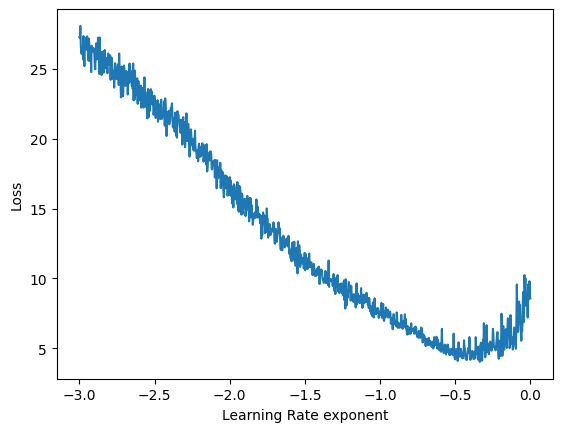

In [149]:
plt.plot(lre, lossi)
plt.xlabel('Learning Rate exponent')
plt.ylabel('Loss')

We see above that after a learning rate of ~0.01, the loss diverges instead of decreasing. So, 0.1 being a the highest permissible learning rate will be our choice.

**NOTE:** The chosen learning rate will vary as you vary batch size. For the dataset in this notebook, the learning rate chosen this way can go as high as 10^(-0.5) if the whole dataset is used for each iteration.

### Sampling from the trained network

In [153]:
max_iters = 20
num_generations = 20
g = torch.Generator().manual_seed(42)

for _ in range(num_generations):
    generation = '.'
    context = [0] * block_size
    for _ in range(max_iters):
        # Get embeddings
        emb = C[context]        # (block_size, embedding_size)

        # Forward pass
        logits = torch.tanh(emb.view(-1, block_size * embedding_size) @ W1.T + b1) @ W2.T + b2  # (1, 27)
        probs = F.softmax(logits, 1)
        
        # Sample according to probabilities and update context
        ix = torch.multinomial(probs, 1, replacement=True, generator=g).item()
        generation += chars[ix]
        context = context[1:] + [ix]

        if ix == 0:
            break
    
    print(generation)


.anusuen.
.tis.
.mari.
.nedan.
.shan.
.silayne.
.arem.
.heli.
.lenna.
.caslee.
.jamzi.
.kence.
.jordon.
.kalla.
.mikhlynn.
.acvi.
.inea.
.zalani.
.nare.
.phes.
